In [1]:
# Install Intel AI libraries and dependencies
!pip install scikit-learn-intelex
!pip install modin[ray]
!pip install daal4py
!pip install openvino
!pip install xgboost
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: tbb
    Found existing installation: tbb 2022.0.0
    Uninstalling tbb-2022.0.0:
      Successfully uninstalled tbb-2022.0.0
  Attempting uninstall: daal
    Found existing installation: daal 2025.0.1
    Uninstalling daal-2025.0.1:
      Successfully uninstalled daal-2025.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [11]:

# Import necessary libraries
import numpy as np
import modin.pandas as mpd
from sklearn.preprocessing import StandardScaler
from sklearnex import patch_sklearn
patch_sklearn()  # Enable Intel optimizations for sklearn
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import time

# Enable Modin with Ray for parallel processing
import ray
ray.init(ignore_reinit_error=True)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2024-12-20 23:29:40,100	INFO worker.py:1654 -- Calling ray.init() again after it has already been called.


Python version:,3.10.12
Ray version:,2.40.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

# Load data using Modin (parallelized Pandas)
train_df = mpd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_train.txt', sep=" ", header=None).dropna(axis=1)
test_df = mpd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_test.txt', sep=" ", header=None).dropna(axis=1)
truth_df = mpd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_truth.txt', sep=" ", header=None).dropna(axis=1)

# Preprocessing
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]
train_df.columns = cols_names
test_df.columns = cols_names
truth_df.columns = ['additional_rul']

train_df['RUL'] = train_df.groupby('id')['cycle'].transform('max') - train_df['cycle']
rul = test_df.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max_cycle']
truth_df['id'] = truth_df.index + 1
truth_df = truth_df.merge(rul, on='id', how='left')
truth_df['RUL'] = truth_df['max_cycle'] + truth_df['additional_rul']
test_df = test_df.merge(truth_df[['id', 'RUL']], on='id', how='left')
test_df['RUL'] = test_df['RUL'] - test_df['cycle']

# Parallelized feature scaling
features = [col for col in cols_names if col not in ['id', 'cycle', 'RUL']]
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

# Prepare data for training and testing
X = train_df[features].values
y = train_df['RUL'].values
X_test = test_df[features].values
y_test = test_df['RUL'].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Intel-optimized XGBoost model
xgb_model = XGBRegressor(tree_method="hist", predictor="cpu_predictor",
                         n_estimators=200, max_depth=8, learning_rate=0.05, subsample=0.8)
train_start = time.time()
xgb_model.fit(X_train, y_train)
train_time_intel = time.time() - train_start
print(f"Training Time with Intel AI Libraries and Parallel Processing: {train_time_intel:.2f} seconds")


Parameters: { "predictor" } are not used.



Training Time with Intel AI Libraries and Parallel Processing: 2.64 seconds


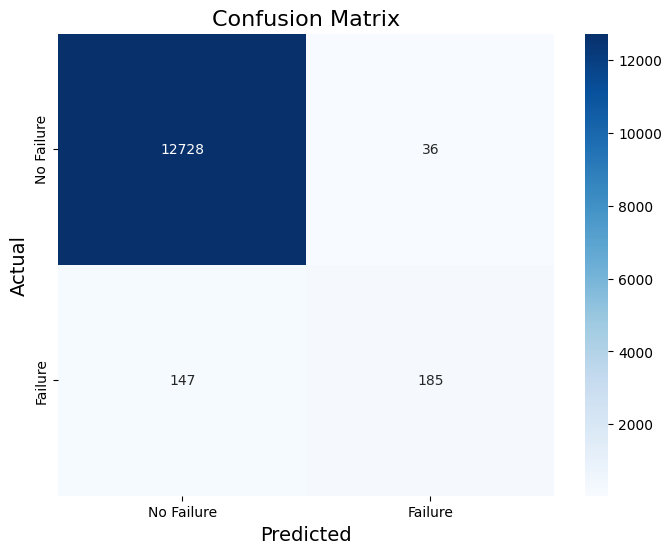

In [9]:

# Predict RUL on validation and test data
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Define a threshold for binary classification (e.g., w1 = 30 cycles)
w1 = 30
y_test_binary = (y_test <= w1).astype(int)  # Actual test labels
y_test_pred_binary = (y_test_pred <= w1).astype(int)

# Print Confusion Matrix for Binary Predictions
conf_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

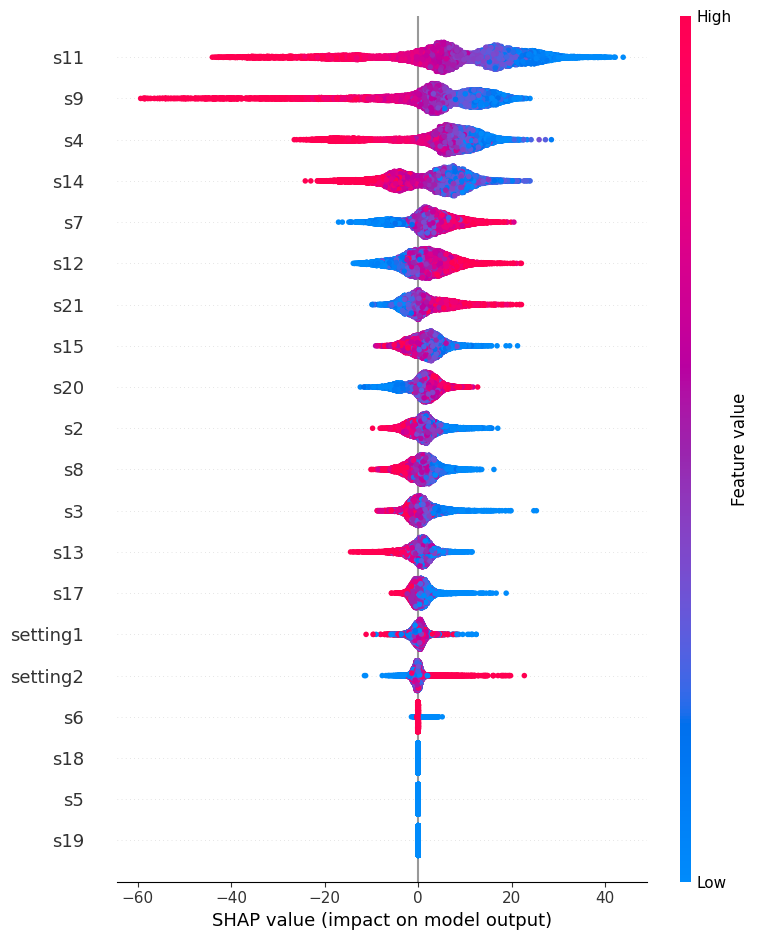

In [12]:

# SHAP Feature Importance
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

In [8]:
# Save the trained XGBoost model as JSON
model_json_path = "xgb_model.json"
xgb_model.get_booster().save_model(model_json_path)
print(f"Model saved in JSON format to {model_json_path}")

Model saved in JSON format to xgb_model.json
